# Note
--- v5 update ---
Adotp new data prepare methord, more clearly and modulized

--- v4 update ---
Adjust many cell, take some nice idea from Li

--- v3 archive ---
Hi Reviewer,

Thanks for your time to review my capestone project. I want to make some note at top to save your time on review my project.

- structure
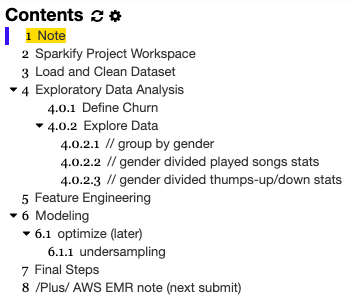

- request for coaching
    - **Q1:How to practice Sprak at real world?** I am new to spark, I manage about 3 week to finish this project, and still get some unclear on part of it. So where can I get some real big data to explore the skill of spark (on AWS, not local). Can you share something?
    - **Q2:Spark vs Flink** I do some research that both Spark and Flink are super-stars nowadays. While Spark come from batch to stream, and Flink come from stream to batch. How shoud I choose from them. Or for the short, what are the pro and cons for Spark and Flink on differed situation?
    
- notice
    - data file: for the git limit < 100MB, I use a compressed file to complete(also the same with 128MB at local, if you want to r

- version 
    - version1 - 
    - version2 - finish uda workplace run out.
    - version3 - finish local run out. (mac env)
    - version4 - (finished at next submit) - aws emr run out, and take a new chaper at the end `/Plus/ AWS EMR note`
    
Thanks a lot again, waiting for you reply.
Meng

# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [6]:
# spark env check（mac）
# java check
!java -version
# 如果不是 1.8 需要
## 关掉jupyter notebook，之后在terminal运行
## export JAVA_HOME=`/usr/libexec/java_home -v 1.8.0_212`
## 如果版本号不对（小版本可能会升级）需要查询 /usr/libexec/java_home -V
## 完成后再次检查版本，输出为类似 java version "1.8.0_212"

# pyspark check
## pyspark 有时需要调整小版本比如从 2.44 - 2.32
## 直接 conda install 就可以变更
## conda install pyspark=2.3
!conda list|grep pyspark

java version "1.8.0_212"
Java(TM) SE Runtime Environment (build 1.8.0_212-b10)
Java HotSpot(TM) 64-Bit Server VM (build 25.212-b10, mixed mode)
pyspark                   2.3.2                    py36_0  


In [7]:
# import libraries

## pyspark sql
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *

## pyspark ml
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler, OneHotEncoderEstimator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## python libs
import matplotlib.pyplot as plt
import re

In [8]:
# create a Spark session
## 如果master没有设定，默认为local，写上更易读
spark = SparkSession.builder \
    .master("local") \
    .appName("Uda_Sparky") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

- 开始使用 mac air 处理 bz2 发现很慢，但其实是数据经过修改的原因
    - 之前是用 pandas 抽出 10% 的数据，但用 pandas 压缩之后有问题
    - 使用操作系统的压缩就OK的，而且压缩率高很多（同一格式）
    - 数据抽取代码归档如下。压缩问题后续再linux工业化时候再测试
    - 可能和Pyspark的读入参数有关，课程中的说明：
        - Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
        - Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
        - PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json
    
```python
## smaller
pddf_small = pddf.sample(frac=0.1)
display(pddf_small.size)
display(pddf_small.head(1))

## new file name
newfile = '10pre_' + file
print(newfile)

## persistence compression
pddf_small.to_json(newfile,compression='bz2')

## persistence normal
pddf_small.to_json('10pre_mini_sparkify_event_data.json')
```

## / Load Original Data(df)

In [9]:
# read df to spark
## 压缩可以节省空间，使用操作系统命令而不是python更加可靠
file_ori = 'mini_sparkify_event_data.json.bz2'
df = spark.read.json(file_ori)
#df.head(1)

## / Clean Data(df->df_clean)
- drop dups
- drop NaNs
- drop null user

In [10]:
# clean df
## na/dup
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"]).dropDuplicates()
## NaN user
df_clean = df_clean.filter(df["userId"] != "")
## count
df_clean.count(),df.count(),df.count()-df_clean.count()

(278154, 286500, 8346)

In [11]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



```
# persistence 在小数据集没关系
## 商业化大数据集再研究
'''
from pyspark import StorageLevel
# df check sample
print('--- persisit ---')
display(df_clean.persist(StorageLevel.MEMORY_ONLY))
## cache 和 persist 都是对 spark 存储的操作
## cache 是默认（RDD在MEM，DataFrame在MEM+Disk）
## 区别说明 https://stackoverflow.com/questions/26870537/what-is-the-difference-between-cache-and-persist
## Leverl可选文档 https://www.tutorialspoint.com/pyspark/pyspark_storagelevel.htm
print('--- userId ---')
display(df_clean.select("userId").sort("userId").show(5))
print('--- sessionId ---')
display(df_clean.select("sessionId").sort("userId").show(5))
''';
'''
```

## / Create Data('Churn')

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [12]:
# this cell generate cancel to boolean, not fit for pipeline, passed
## 使用 Cancellation Confirmation 来定义客户流失
'''
cancel_user_df = df_clean.filter(df_clean.page=="Cancellation Confirmation").select("userId").dropDuplicates()
cancel_user_list = [user["userId"] for user in cancel_user_df.collect()]
display(cancel_user_list[:10])

## create column for canceled or not user on category type
df_clean = df_clean.withColumn("cancel", df_clean.userId.isin(cancel_user_list))
''';

In [13]:
# another methord create 'cancel'
## 这种方法输出的是 interger
df_clean = df_clean.withColumn('cancel', when((df_clean.page == 'Cancellation Confirmation') | (df_clean.page == 'Downgrade'), 1 ).otherwise(0))

## / Check Data

In [14]:
df_clean.printSchema(),df_clean.show(1)
## 最后多一列‘cancel’就对了

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- cancel: integer (nullable = false)

+---------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----+------+-------------+--------------------+------+------+
|         artist|     auth|firstName|gender|itemInSession|

(None, None)

In [15]:
df_clean.select('cancel').show()

+------+
|cancel|
+------+
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
+------+
only showing top 20 rows



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

## / Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [ ]:
# check all data
display(df_clean.head(1))
## .show 的输出在jupyter 特别不友好，列多的话很难读
## .head 又没有table样式的输出

In [ ]:
## 挑选比较重要的列展示
## 从数据看 page 记录的是当听歌的时候用户都点击了什么
df_clean.select(["page","artist",'song','level','userId']).show(5)

In [ ]:
# dorpDuplicates 用法是对所有选中列进行的。对比下这3个
## 好像pandas不是这样的，后续测试下
display(df_clean.select(["page","userId",'gender']).dropDuplicates().show(5))
display(df_clean.select(['gender',"page","userId"]).dropDuplicates().show(5))
display(df_clean.select(['gender',"page"]).dropDuplicates().show(5))

In [ ]:
# filter cancel user
## 检查下 Page 里的 Cancel 操作
display(df_clean.select("page").dropDuplicates().show(5))

### // group by gender

In [ ]:
# group by gender
## 联合的看（看不到总数）
display(df_clean.dropDuplicates(['userId']).groupby(['gender','cancel']).count().show())
## 分开看
display(df_clean.dropDuplicates(['userId']).groupby(['gender']).count().show())
display(df_clean.dropDuplicates(['userId']).groupby(['cancel']).count().show())

### // gender divided played songs stats

In [ ]:
# gender divided played songs stats
## 转成pandas再画图
pd_songs = df_clean.where(df_clean.song!='null').groupby(['cancel','userId']) \
    .agg(count(df_clean.song).alias('SongsPlayed')).orderBy('cancel').toPandas()

In [ ]:
pd_songs.head()

In [ ]:
# 其实到用户来讲mini的数量真的很少
pd_songs.query('cancel == False').shape[0],pd_songs.query('cancel == True').shape[0]

In [ ]:
## 可以看出来取关的人听歌更少（x是听歌数量，y是出现次数）
pd_songs.groupby(['cancel']).hist(bins=50);

In [ ]:
# 加个 by 可以按照 cancel False 和 True 画图（左和右）
## 图形颜色是把出现类别做多的画为不同颜色，和分类无关（想了好半天才想通）
pd_songs.hist(by='cancel',bins=20);

### // length statistic

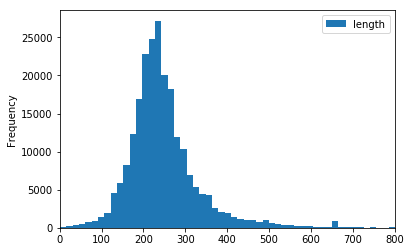

In [28]:
# idea form LK
pd_length = df_clean.select('length').toPandas()
pd_length.plot.hist(bins=200,xlim=(0,800));
## 终于对 xlim 下手了
## 注意由于 pandas 库的历史原因 DataFrame.hist 不支持xlim参数
## DataFrame.plot.hist 就可以

### // gender divided thumps-up/down stats

In [29]:
# gender divided thumps-up/down stats
pd_up = df_clean.where(df_clean.page=='Thumbs Up') \
    .groupby(['cancel','userId']).agg(count(col('page')).alias('ThumbsUps')).orderBy('cancel').toPandas()
pd_down = df_clean.where(df_clean.page=='Thumbs Down') \
    .groupby(['cancel','userId']).agg(count(col('page')).alias('ThumbsDowns')).orderBy('cancel').toPandas()

print('ThumbsUps for people who stay',
      pd_up[pd_up['cancel']==False]['ThumbsUps'].mean())
print('ThumbsUps for people who leave',
      pd_up[pd_up['cancel']==True]['ThumbsUps'].mean())
print('ThumbsDowns for people who stay',
      pd_down[pd_down['cancel']==False]['ThumbsDowns'].mean())
print('ThumbsDowns for people who leave',
      pd_down[pd_down['cancel']==True]['ThumbsDowns'].mean())

ThumbsUps for people who stay 62.89411764705882
ThumbsUps for people who leave 37.18
ThumbsDowns for people who stay 13.225806451612904
ThumbsDowns for people who leave 10.333333333333334


In [30]:
pd_up.columns

Index(['cancel', 'userId', 'ThumbsUps'], dtype='object')

In [31]:
pd_up['cancel'].value_counts()

False    170
True      50
Name: cancel, dtype: int64

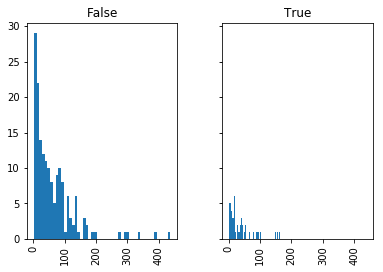

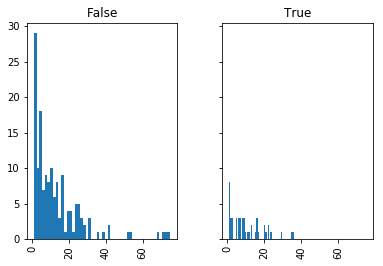

In [32]:
## visulize
pd_up.hist('ThumbsUps', by='cancel', bins=50, sharex=True, sharey=True);
pd_down.hist('ThumbsDowns', by='cancel', bins=50, sharex=True, sharey=True);

## sharex,sharey 是标记x和y的坐标相同，便于对比
## 尝试使用了下 .post.hist 限制x，结果 by 处报错，再研究
## 如果加上了 density=1 就是进行密度转换，后续研究

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

- Numeric Feature
- Category Feature

## / Numeric Feature

In [16]:
# feature1 gender
df_gender = df_clean.dropDuplicates(['userId']).sort('userId').select(['userId','gender'])
df_gender = df_gender.replace(['F','M'], ['1', '0'], 'gender')
df_gender = df_gender.withColumn('gender', df_gender.gender.cast("int"))

In [17]:
df_gender.show(10),df_gender.dtypes

+------+------+
|userId|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     1|
|100003|     1|
|100004|     1|
|100005|     0|
|100006|     1|
|100007|     1|
|100008|     1|
+------+------+
only showing top 10 rows



(None, [('userId', 'string'), ('gender', 'int')])

In [18]:
# feature2 played songs
df_songs = df_clean.where(df_clean.song!='null').groupby('userId') \
    .agg(count(df_clean.song).alias('SongsPlayed')).orderBy('userId') \
    .select(['userId','SongsPlayed'])

In [19]:
df_songs.show(10),df_songs.dtypes

+------+-----------+
|userId|SongsPlayed|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
|100004|        942|
|100005|        154|
|100006|         26|
|100007|        423|
|100008|        772|
+------+-----------+
only showing top 10 rows



(None, [('userId', 'string'), ('SongsPlayed', 'bigint')])

In [20]:
# feature3 thumps up/down
df_thumbsup = df_clean.where(df_clean.page=='Thumbs Up') \
    .groupby(['userId']).agg(count(col('page')).alias('ThumbsUps')).orderBy('userId').select(['userId','ThumbsUps'])
df_thumbsdown = df_clean.where(df_clean.page=='Thumbs Down') \
    .groupby(['userId']).agg(count(col('page')).alias('ThumbsDowns')).orderBy('userId').select(['userId','ThumbsDowns'])

In [21]:
df_thumbsup.show(10),df_thumbsup.dtypes,df_thumbsdown.show(10),df_thumbsdown.dtypes

+------+---------+
|userId|ThumbsUps|
+------+---------+
|    10|       37|
|   100|      148|
|100001|        8|
|100002|        5|
|100003|        3|
|100004|       35|
|100005|        7|
|100006|        2|
|100007|       19|
|100008|       37|
+------+---------+
only showing top 10 rows

+------+-----------+
|userId|ThumbsDowns|
+------+-----------+
|    10|          4|
|   100|         27|
|100001|          2|
|100004|         11|
|100005|          3|
|100006|          2|
|100007|          6|
|100008|          6|
|100009|          8|
|100010|          5|
+------+-----------+
only showing top 10 rows



(None,
 [('userId', 'string'), ('ThumbsUps', 'bigint')],
 None,
 [('userId', 'string'), ('ThumbsDowns', 'bigint')])

In [22]:
# feature4 singers number
df_singers = df_clean.dropDuplicates(['userId','artist']).groupby('userId') \
    .agg(count(df_clean.artist).alias('SingersListened')).orderBy('userId') \
    .select(['userId','SingersListened'])

In [23]:
df_singers.show(10),df_singers.dtypes

+------+---------------+
|userId|SingersListened|
+------+---------------+
|    10|            565|
|   100|           1705|
|100001|            125|
|100002|            184|
|100003|             50|
|100004|            733|
|100005|            149|
|100006|             26|
|100007|            357|
|100008|            623|
+------+---------------+
only showing top 10 rows



(None, [('userId', 'string'), ('SingersListened', 'bigint')])

In [24]:
# feature5 total played time
df_totaltime = df_clean.groupBy('userId').agg(sum('length').alias('TotalTime'))

In [25]:
df_totaltime.show(10),df_totaltime.dtypes

+------+------------------+
|userId|         TotalTime|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999998|
|   125|         2089.1131|
|    51|523275.84280000004|
|   124|1012312.0927900008|
|     7| 38034.08710000001|
|    15| 477307.6058100001|
|    54| 711344.9195399994|
|   155|       198779.2919|
|   132|      483118.90384|
+------+------------------+
only showing top 10 rows



(None, [('userId', 'string'), ('TotalTime', 'double')])

## / Category Feature

In [26]:
# already done at clean dataset
# create 'cancel' first
#Pass此节内容，后面在pipeline有indexer方法直接处理label
#from pyspark.sql.functions import *
#df_clean = df_clean.withColumn('cancel', when((df_clean.page == 'Cancellation Confirmation') | (df_clean.page == 'Downgrade'), 1 ).otherwise(0))

In [27]:
#df_category_ = df_clean.select('cancel', 'gender', 'level', 'location') 
df_category_ = df_clean.select('userId', 'gender', 'level', 'location') 

In [28]:
df_category_.show(),df_category_.dtypes

+------+------+-----+--------------------+
|userId|gender|level|            location|
+------+------+-----+--------------------+
|    78|     F| free|McAllen-Edinburg-...|
|    78|     F| free|McAllen-Edinburg-...|
|    25|     F| paid|Tampa-St. Petersb...|
|    15|     M| paid|      Morgantown, WV|
|    27|     M| free|Hartford-West Har...|
|    51|     M| paid|Lexington-Fayette...|
|    93|     M| free|Allentown-Bethleh...|
|    81|     M| paid|Philadelphia-Camd...|
|    54|     F| paid|Spokane-Spokane V...|
|    53|     M| free|         Jackson, MS|
|    51|     M| paid|Lexington-Fayette...|
|   115|     F| free|Los Angeles-Long ...|
|   115|     F| free|Los Angeles-Long ...|
|    98|     M| free|Houston-The Woodl...|
|   142|     M| paid|New York-Newark-J...|
|    92|     F| free|Boston-Cambridge-...|
|   124|     F| paid|Vineland-Bridgeto...|
|    29|     M| free|Los Angeles-Long ...|
|    87|     M| free|       Quincy, IL-MO|
|   124|     F| paid|Vineland-Bridgeto...|
+------+---

(None,
 [('userId', 'string'),
  ('gender', 'string'),
  ('level', 'string'),
  ('location', 'string')])

In [29]:
#split location into two new columns, location and country
df_category_ = df_category_.withColumn('location_list', split(df['location'], ','))
df_category_ = df_category_.withColumn('location', df_category_.location_list[0])
df_category_ = df_category_.withColumn('country', df_category_.location_list[1]).drop('location_list')

In [30]:
#对用户进行聚合
#na drop在LoadData处已经完成
#df_category_ = df_category_.dropDuplicates(subset=['userId'])

In [31]:
# convert all the categorical features into nurmeric

category_list = ['gender', 'level', 'location', 'country']

for f in category_list:
    stringIndexer = StringIndexer(inputCol=f, outputCol=f + "Index")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()],
                                     outputCols=[f + "classVec"])
    model = stringIndexer.fit(df_category_)
    df_category_ = model.transform(df_category_)

In [32]:
#drop original categorical features
# *就是求补集
df_category_ = df_category_.drop(*category_list)

In [33]:
df_category_.show(),df_category_.dtypes,df_category_.count()

+------+-----------+----------+-------------+------------+
|userId|genderIndex|levelIndex|locationIndex|countryIndex|
+------+-----------+----------+-------------+------------+
|    78|        0.0|       1.0|         91.0|         2.0|
|    78|        0.0|       1.0|         91.0|         2.0|
|    25|        0.0|       0.0|         32.0|         4.0|
|    15|        1.0|       0.0|         36.0|        32.0|
|    27|        1.0|       1.0|         48.0|        11.0|
|    51|        1.0|       0.0|         33.0|        23.0|
|    93|        1.0|       1.0|         79.0|        47.0|
|    81|        1.0|       0.0|          7.0|        12.0|
|    54|        0.0|       0.0|         21.0|        21.0|
|    53|        1.0|       1.0|         19.0|        18.0|
|    51|        1.0|       0.0|         33.0|        23.0|
|   115|        0.0|       1.0|          0.0|         0.0|
|   115|        0.0|       1.0|          0.0|         0.0|
|    98|        1.0|       1.0|          3.0|         2.

(None,
 [('userId', 'string'),
  ('genderIndex', 'double'),
  ('levelIndex', 'double'),
  ('locationIndex', 'double'),
  ('countryIndex', 'double')],
 278154)

## / Join Features

In [34]:
# join features
# 搞定，numeric的应该细化为 _numeric_小库，后续调整
df_final = df_clean.dropDuplicates(['userId']).sort('userId').select(['userId','cancel'])
for feature in [df_gender, df_songs,df_thumbsup,df_thumbsdown,df_singers,df_category_]:
    df_final = df_final.join(feature,'userId')

In [35]:
df_final.show(10),df_final.dtypes

KeyboardInterrupt: 

In [ ]:
# use churn not cancel
#df_final = df_final.drop('cancel')
#df_final.dtypes

## / Drop UserId (passed)

In [ ]:
#df_final = df_finail.drop('userId')
#df_finail.printSchema()
## 不能drop userid 因为是id对应多操作的情况，否则无法有效聚合做分析

## / Persistence

In [ ]:
### file persistence
## saving to csv
#file = 'mini_sparkify_event_data_final_5.csv'
#df_final.write.save(file, format="csv", header=True)
## header = True 是提醒数据是否带header的参数，写入和读取保持一致即可
## df_final.write.save(file_finail, format="json") 会报错
## 在spark2.3之后对json格式有要求，优先使用csv
## 写出来是一个目录，是因为spark是分布式处理的，集合成一个文件后续研究
## ！！！ 发现spark存储的数据再读入会失去数据类型，都变成string可能和版本有关

In [ ]:
## saving to json
#file = 'mini_sparkify_event_data_final_5.json'
#df_final.write.save(file, format="json")

In [ ]:
#df_final.dtypes

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## / Load Data

In [ ]:
## read final data (much quick for show)
#df = spark.read.csv(file_finial, header=True)
#df = spark.read.csv(file, header=True)
df = df_final
df.show(1),df.dtypes

In [ ]:
## drop userID 对回归无用
df = df.drop('userId')
df.dtypes

In [ ]:
# not need to float
'''
# convert data type of columns into float
for feature in df.columns[1:]:
    df_final = df.withColumn(feature,df[feature].cast('float'))
df_final.dtypes
''';

In [ ]:
# get feature_lists
feature_list = df.drop('cancel').columns
feature_list

## / Vector Data

In [ ]:
# check data types
#print(df.dtypes)
#df.show(5)
# check sample
# !!! lazy !!!
## 特别慢！这里 show|head、 在mac 和windows很慢,原因是 spark 的 lazy 机制
## df_clean.show(1) 就很快
## df_final.show(1) 慢很多是因为前面的各种 .methord 在这里才执行，所以很慢
## 在上一节增加持久化的工作就可解决（spark有没有别的方法？）

In [ ]:
# vector
## assembler 
assembler = VectorAssembler(inputCols=feature_list,
                            outputCol='assembler')
## run (not run if use pipeline)
#sample = assembler.transform(df)

In [ ]:
#sample.show(5)

In [ ]:
## scaler
scaler = StandardScaler(inputCol="assembler",
                        outputCol="scaler")
## 貌似scaler的使用和算法的默认代入列有关系，lr的output要是scaled
## 先解决问题细节后续研究
'''
scaler_lr = StandardScaler(inputCol="vectored",
                        outputCol="scaled",
                        withStd=True)
''';
## run (not run if use pipeline)
#sample = scaler.fit(sample).transform(sample)

In [ ]:
## indexer
#如果数据前面没有把 cancel 处理为 0/1 标记，这里可以用 indexer 进行处理
#indexer = StringIndexer(inputCol="cancel", outputCol="label")
indexer = StringIndexer(inputCol="churn", outputCol="label")
stringIndexer = StringIndexer(inputCol="label", outputCol="indexed")

In [ ]:
# check sample
#sample.show(5),sample.dtypes

In [ ]:
# fit (assembler -> scaler -> fit)
## 使用assembler进行vec转换
#sample = assembler.transform(df)
## 使用scaler进行标尺转换
#sample = scaler.fit(sample).transform(sample)

In [ ]:
'''
# seems not need
# convert data type of columns into float
for feature in df_final.columns[1:]:
    df_final = df_final.withColumn(feature,df_final[feature].cast('float'))
    
df_final.dtypes
''';

## / Split Data 

In [ ]:
# data split
train, test = df.randomSplit([0.8, 0.2],seed=42)

In [ ]:
train.dtypes,test.dtypes

## / Algorithm

### // logistic regression

In [ ]:
## algorithm
alg_lr =  LogisticRegression(labelCol='churn',
                             featuresCol='scaler',
                             maxIter=10, regParam=0.3, elasticNetParam=0.8)

## grid
grid_lr = ParamGridBuilder() \
    .addGrid(alg_lr.elasticNetParam,[0.0, 1.0]) \
    .addGrid(alg_lr.regParam,[0.0, 0.1]) \
    .build()

## validator
vali_lr = BinaryClassificationEvaluator()

## pipeline
pipeline_lr = Pipeline(stages=[assembler, scaler, indexer, stringIndexer, alg_lr])
#pipeline_lr = Pipeline(stages=[assembler, scaler, alg_lr])

## cross validation
crossval_lr = CrossValidator(estimator=pipeline_lr,
                        estimatorParamMaps=grid_lr,
                        evaluator=vali_lr,
                        numFolds=2)

cvModel_lr = crossval_blr.fit(train)

In [ ]:
## summary
trainingSummary = cvModel_lr.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)

### // logistic regression (binomial)

In [ ]:
## algorithm
alg_blr =  LogisticRegression(labelCol='cancel',
                             featuresCol='scaler',
                             maxIter=10, regParam=0.3, elasticNetParam=0.8,
                             family="multinomial")

## grid
grid_blr = ParamGridBuilder() \
    .addGrid(alg_lr.elasticNetParam,[0.0, 1.0]) \
    .addGrid(alg_lr.regParam,[0.0, 0.1]) \
    .build()

## validator
vali_blr = BinaryClassificationEvaluator()

## pipeline
pipeline_blr = Pipeline(stages=[assembler, scaler, indexer, stringIndexer, alg_blr])
#pipeline_lr = Pipeline(stages=[assembler, scaler, alg_lr])

## cross validation
crossval_blr = CrossValidator(estimator=pipeline_blr,
                        estimatorParamMaps=grid_blr,
                        evaluator=vali_blr,
                        numFolds=2)

cvModel_blr = crossval_blr.fit(train)

### // (pass not use pipeline)

In [ ]:
#Evaluating Logitical Regression

evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='cancel')

print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train_lr)))
## algorithm
alg_lr =  LogisticRegression(labelCol='cancel',
                             featuresCol='scaler',
                             maxIter=10, regParam=0.001)

model_lr = alg_lr.fit(train)
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test_lr)))

In [ ]:
#Train the model with RF
model_rf = RandomForestClassifier(labelCol='cancel',
                             featuresCol='scaler')
model_rf = model_rf.fit(train)

In [ ]:
#predictions
predict_train_rf = model_rf.transform(train)
predict_test_rf = model_rf.transform(test)

In [ ]:
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train_rf)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test_rf)))

In [ ]:
# lr
## algorithm
alg_lr =  LogisticRegression(labelCol='cancel',
                             featuresCol='scaler',
                             maxIter=10, regParam=0.001)

## grid
grid_lr = ParamGridBuilder() \
    .addGrid(alg_lr.elasticNetParam,[0.0, 0.5, 1.0]) \
    .addGrid(alg_lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

## validator
vali_lr = BinaryClassificationEvaluator()

## pipeline
#pipeline_lr = Pipeline(stages=[assembler, scaler_lr, indexer, alg_lr])
#pipeline_lr = Pipeline(stages=[assembler, scaler, alg_lr])
pipeline_lr = Pipeline(stages=[alg_lr])

## cross validation
crossval_lr = CrossValidator(estimator=pipeline_lr,
                        estimatorParamMaps=grid_lr,
                        evaluator=vali_lr,
                        numFolds=3)

cvModel_lr = crossval_lr.fit(train)

In [ ]:
# lr
## algorithm
alg_lr =  LogisticRegression(maxIter=10, regParam=0.001)

## grid
grid_lr = ParamGridBuilder() \
    .addGrid(alg_lr.elasticNetParam,[0.0, 0.5, 1.0]) \
    .addGrid(alg_lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

## validator
vali_lr = BinaryClassificationEvaluator()

## pipeline
#pipeline_lr = Pipeline(stages=[assembler, scaler_lr, indexer, alg_lr])
#pipeline_lr = Pipeline(stages=[assembler, scaler, alg_lr])
pipeline_lr = Pipeline(stages=[alg_lr])

## cross validation
crossval_lr = CrossValidator(estimator=pipeline_lr,
                        estimatorParamMaps=grid_lr,
                        evaluator=vali_lr,
                        numFolds=3)

cvModel_lr = crossval_lr.fit(train)

### // decision tree

In [ ]:
# dt
## algorithm
dt = DecisionTreeClassifier()

## pipeline
pipeline_dt = Pipeline(stages=[assembler, scaler, indexer, stringIndexer, dt])
paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[3, 5, 7]) \
    .build()
crossval_dt = CrossValidator(estimator=pipeline_dt,
                          estimatorParamMaps=paramGrid_dt,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)

## fit
cvModel_dt = crossval_dt.fit(train)

In [ ]:
# rf
## algorithm
#rf = RandomForestClassifier(numTrees=3, maxDepth=2, labelCol="indexed", seed=42)

In [ ]:
# gbt
## algorithm
gbt = GBTClassifier()

## pipeline
pipeline_gbt = Pipeline(stages=[assembler, scaler, indexer, stringIndexer, gbt])
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[10, 20]) \
    .addGrid(gbt.maxDepth,[4, 8]) \
    .build()
crossval_gbt = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

## fit
cvModel_gbt = crossval_gbt.fit(train)

In [ ]:
# result
display('--- lr ---', cvModel_lr.avgMetrics)
display('--- lrb ---', cvModel_lrb.avgMetrics)
display('--- dt ---', cvModel_dt.avgMetrics)
display('--- gbt ---', cvModel_gbt.avgMetrics)

## optimize (later)
### undersampling

In [ ]:
# undersampling
## use sampleBy,but shoud done before trans of data
## http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.sampleBy
#stratified_train = train.sampleBy('label', fractions={0: 99/349, 1: 1.0}).cache()
#stratified_train.groupby("label").count().show()
# later

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

# /Plus/ AWS EMR note (next submit)